# Imports

In [78]:
import pandas as pd
import datetime as dt
import numpy as np
import random

from skautobots.date_processing import DateLinear

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Basic Example

## Build Dataset

We will start our dataset on January 1st 2015 and generate dates for the next 1500 days. Then we will use the transformer to get the different linear pieces of the date.

In [10]:
start_date = dt.datetime(year=2015, month=1, day=1)
days_out = 1500

In [11]:
basic_df = pd.DataFrame.from_records(
    [
        {
            'x': x,
            'date': start_date + dt.timedelta(days=x)
        } for x in range(days_out)
    ]
)

Check the dataframe.

In [12]:
basic_df.head()

,x,date
0,0,2015-01-01
1,1,2015-01-02
2,2,2015-01-03
3,3,2015-01-04
4,4,2015-01-05


## Load Transformer

To create the transformer we pass in the columns we would like to transform, the periods that we would like to capture and whether or not we want the original datetime columns dropped.

In [13]:
date_transformer = DateLinear(
    cols=['date'], 
    periods=['dayofweek', 'dayofmonth', 'dayofyear', 'year', 'dayofweek', 'monthofyear'],
    drop_base_cols=False
)

We then use the scikit-learn fit/transform api to transform our data.

## Transform Data

In [14]:
transformed_df = date_transformer.fit_transform(basic_df)

In [15]:
transformed_df.head(40).tail(20)

,x,date,date_day_of_week,date_day_of_month,date_day_of_year,date_month,date_year
20,20,2015-01-21,2,21,21,1,2015
21,21,2015-01-22,3,22,22,1,2015
22,22,2015-01-23,4,23,23,1,2015
23,23,2015-01-24,5,24,24,1,2015
24,24,2015-01-25,6,25,25,1,2015
25,25,2015-01-26,0,26,26,1,2015
26,26,2015-01-27,1,27,27,1,2015
27,27,2015-01-28,2,28,28,1,2015
28,28,2015-01-29,3,29,29,1,2015
29,29,2015-01-30,4,30,30,1,2015


In [16]:
transformed_df.tail(10)

,x,date,date_day_of_week,date_day_of_month,date_day_of_year,date_month,date_year
1490,1490,2019-01-30,2,30,30,1,2019
1491,1491,2019-01-31,3,31,31,1,2019
1492,1492,2019-02-01,4,1,32,2,2019
1493,1493,2019-02-02,5,2,33,2,2019
1494,1494,2019-02-03,6,3,34,2,2019
1495,1495,2019-02-04,0,4,35,2,2019
1496,1496,2019-02-05,1,5,36,2,2019
1497,1497,2019-02-06,2,6,37,2,2019
1498,1498,2019-02-07,3,7,38,2,2019
1499,1499,2019-02-08,4,8,39,2,2019


Boom we've got all of the individual linear pieces from the date column.

# Regression Example

## Build Sample Dataset

Generate a number of samples and generate a number of y samples based on some of the linear terms of the date. We will use the formula:
    $$ 2 * (dayofmonth) + 10 * (year - 2000) - (dayofweek) + noise $$
We will use  guassian noise with a mean of 0 and standard deviation of 1.

In [54]:
noise_mu = 0
noise_sigma = 3
def y_formula(sample_date):
    return (
        (2 * sample_date.day) + 
        10 * (sample_date.year - 2000) - 
        (sample_date.weekday()) + 
        np.random.normal(noise_mu, noise_sigma)
    )

First we set the number of samples, the start sample date and the max time in the future for the records to be in.

In [55]:
number_of_samples = 10_000
max_days_out = 1200
start = dt.datetime(year=2015, month=1, day=1) 

In [56]:
records = []
for _ in range(number_of_samples):
    x = random.randint(0, max_days_out)
    sample_date = start + dt.timedelta(days=x)
    records.append({
        'sample_date': sample_date,
        'y': y_formula(sample_date)
    })
regression_df = pd.DataFrame.from_records(records)

Review dataframe.

In [57]:
regression_df.head()

,sample_date,y
0,2017-06-04,169.591900
1,2015-02-21,185.213686
2,2017-12-21,210.378502
3,2016-09-18,189.119066
4,2016-01-01,155.671469


## Visualize the Data

Some visualizations. Let's start with the full time period.

(735599.0, 736799.0)

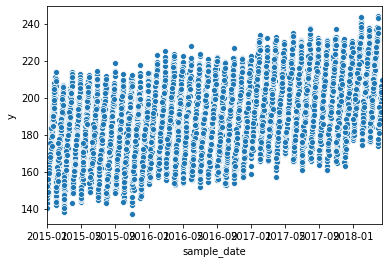

In [63]:
sns.scatterplot(x='sample_date', y='y', data=regression_df)
plt.xlim((start, start + dt.timedelta(days=max_days_out)))

Then several months.

(735599.0, 735699.0)

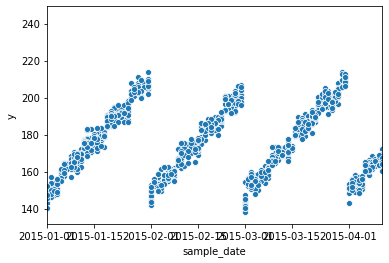

In [64]:
sns.scatterplot(x='sample_date', y='y', data=regression_df)
plt.xlim((start, start + dt.timedelta(days=100)))

Let's look at 3 weeks of data.

(735599.0, 735620.0)

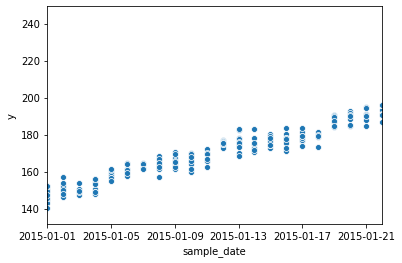

In [65]:
sns.scatterplot(x='sample_date', y='y', data=regression_df)
plt.xlim((start, start + dt.timedelta(days=21)))

## Build Pipeline and Regressor

In [71]:
date_transformer = ColumnTransformer(
    [('city_category', 
      DateLinear(
          cols=['sample_date'],
          periods=['year', 'dayofweek', 'dayofmonth']),
      ['sample_date'])
    ],
     remainder='drop')

In [72]:
estimators = [('date_transformer', date_transformer), ('lr', LinearRegression())]
pipe = Pipeline(estimators)

In [73]:
X = regression_df[['sample_date']]
y = regression_df[['y']].values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Fit Pipeline

In [76]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('date_transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('city_category',
                                                  DateLinear(cols=['sample_date'],
                                                             drop_base_cols=True,
                                                             periods=['year',
                                                                      'dayofweek',
                                                                      'dayofmonth']),
                                                  ['sample_date'])],
                                   verbose=False)),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],


## Make Predictions and Evaluate

In [77]:
y_pred = pipe.predict(X_test)

Let's look at the coefficients.

In [82]:
pipe['lr'].coef_

array([[-1.01820992,  1.99868885, 10.00207406]])

That's pretty close to our coefficients from the original formula! Let's see how our model predicts against new data.

In [85]:
np.sqrt(mean_squared_error(y_test, y_pred))

3.021765962157514

Considering the $\sigma$ for our noise was 3 this is about as well as we could expect to perform.